In [2]:
from packaging import version
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os
import scipy
from collections import defaultdict
from functools import partial
from  matplotlib.ticker import FuncFormatter
import torch
import numpy as np

In [3]:
def load_exp(exp_name):
    dir_path = Path(
        "/home/xt0r3-user/cambridge/partii/dissertation/s3prl/s3prl/s3prl/result/downstream/"
    )

    if not (dir_path / exp_name / "log.log").exists():
        return {}

    with open(dir_path / exp_name / "log.log") as f:
        for line in f:
            if line.startswith("mdd/test"):
                test_metric_line = line
            if line.startswith("mdd/dev"):
                dev_metric_line = line

    test_metrics_list = test_metric_line.split("|")[1:-1]
    dev_metrics_list = dev_metric_line.split("|")[1:-1]

    test_metrics = dict(
        [tuple(metric_pair.split(":")) for metric_pair in test_metrics_list]
    )

    dev_metrics = dict(
        [tuple(metric_pair.split(":")) for metric_pair in dev_metrics_list]
    )

    return {
        "test": test_metrics,
        "dev": dev_metrics,
    }
    # sns.lineplot(dfx, x='step', y='value', hue='name', errorbar=None)

In [4]:
models = [
    "wav2vec2",
    "wavlm_large",
    "wavlm_base_plus",
    "multires_hubert_multilingual_large600k",
    "multires_hubert_multilingual_large400k",
    # "multires_hubert_multilingual_base",
    # "multires_hubert_base",
    "multires_hubert_large",
    "wavlablm_ms_40k",
    "hubert",
    "decoar2",
]

# metric_list = ['f1_score', 'recall', 'precision', 'loss', 'per']
# splits=['dev', 'test']
# parsed_metrics = []
# for split in splits:
#     for metric in metric_list:
#         parsed_metrics.append(f"{split}_{metric}")

In [5]:
metrics = defaultdict(dict)
for augmentation in models:
    for i in range(1, 6):
        exp = (load_exp(f"model_{augmentation}_{i}"))
        if exp != {}:
            metrics[augmentation][i]=exp
        # print(f"{i}_{augmentation}")
        # display(dfx.loc['dev_f1_score'].isna().any())
        # print(dfx.loc[metric]['value'])

df = pd.json_normalize(metrics)
df.columns = pd.MultiIndex.from_tuples(df.columns.str.split('.').to_series().apply(tuple))
df = df.stack(1).droplevel(0, axis=0).astype(float)
df = df.swaplevel(0, 1, axis=1)
df

dev                                                  \
        decoar2                                                   
  corr_diag_pct deletions err_diag_pct  f1_score     fn      fp   
1      0.515127     956.0     0.365914  0.425463  296.0  1711.0   
2      0.505898    1000.0     0.375143  0.430170  292.0  1711.0   
3      0.518080     864.0     0.366679  0.429742  308.0  1628.0   
4      0.523526     862.0     0.350080  0.430765  284.0  1669.0   
5      0.511214     912.0     0.366110  0.421641  326.0  1613.0   

                                                             ...        test  \
                                                             ... wavlm_large   
  global-f1-score global-per global-precision global-recall  ...  insertions   
1        0.490997   0.257645         0.361329      0.765823  ...       617.0   
2        0.492526   0.259350         0.362281      0.768987  ...       505.0   
3        0.496881   0.249973         0.369969      0.756329  ...       452.0   
4        0.501149   0.251039         0.370189      0.775494  ...       417.0   
5        0.491743   0.249014         0.367699      0.742089  ...       441.0   

                                                                               \
                                                                                
        loss num_ref_tokens        per precision    recall step substitutions   
1  20.133181        31187.0  15.534954  0.456097  0.510106  0.0        3353.0   
2  20.300358        31187.0  15.846690  0.460069  0.527022  0.0        3427.0   
3  17.727709        31187.0  15.383341  0.480067  0.550500  0.0        3269.0   
4  17.469305        31187.0  15.131537  0.487080  0.537641  0.0        3237.0   
5  17.369894        31187.0  15.264741  0.477159  0.551430  0.0        3285.0   

                    
                    
        tn      tp  
1  25303.0  2475.0  
2  25129.0  2533.0  
3  25146.0  2624.0  
4  25221.0  2575.0  
5  25140.0  2631.0  

[5 rows x 360 columns]

In [6]:
scipy.stats.ttest_ind(np.zeros(10), np.ones(10) + np.random.normal(0, 0.1, 10))

Ttest_indResult(statistic=-34.29791471938794, pvalue=7.490638748474476e-18)

In [7]:
metric_list = [
    'loss',
    'global-per',
    'global-precision',
    # 'global-recall',
    'global-f1-score',

]

In [8]:
splits = ['test', 'dev']

In [9]:
results = []
small_augs = list(set(models) - {"wav2vec2"})
for augmentation in small_augs:
    cur_res = []
    for split in splits:
        for metric in metric_list:
            result = scipy.stats.ttest_ind(
                df[(split, "wav2vec2", metric)].dropna(),
                df[(split, augmentation, metric)].dropna(),
            )
            cur_res.append(result.pvalue)
            cur_res.append(result.statistic)
    results.append(cur_res)

In [10]:
results[0]

[1.465722885211621e-07,
 -16.984331462585978,
 6.49752609729124e-08,
 -18.84536301085526,
 2.0429642788723906e-06,
 12.076130953409418,
 0.002205765634094599,
 4.427014659702499,
 1.9763042662179745e-07,
 -16.345692535716058,
 3.100872099531009e-06,
 -11.4313771112971,
 8.236791607602736e-06,
 10.040338289753414,
 0.04807397763344322,
 2.3311676802742447]

In [11]:
res_df = pd.DataFrame(
    results,
    index=small_augs,
    columns=pd.MultiIndex.from_product([splits, metric_list, ["pvalue", "statistic"]]),
).loc(axis=1)[:, :, :]#"pvalue"]

res_df.sort_values(by=('test', 'global-precision', 'pvalue')).style.highlight_between(color="green", right=0.05)

In [12]:
df.mean().index

MultiIndex([( 'dev',     'decoar2',    'corr_diag_pct'),
            ( 'dev',     'decoar2',        'deletions'),
            ( 'dev',     'decoar2',     'err_diag_pct'),
            ( 'dev',     'decoar2',         'f1_score'),
            ( 'dev',     'decoar2',               'fn'),
            ( 'dev',     'decoar2',               'fp'),
            ( 'dev',     'decoar2',  'global-f1-score'),
            ( 'dev',     'decoar2',       'global-per'),
            ( 'dev',     'decoar2', 'global-precision'),
            ( 'dev',     'decoar2',    'global-recall'),
            ...
            ('test', 'wavlm_large',       'insertions'),
            ('test', 'wavlm_large',             'loss'),
            ('test', 'wavlm_large',   'num_ref_tokens'),
            ('test', 'wavlm_large',              'per'),
            ('test', 'wavlm_large',        'precision'),
            ('test', 'wavlm_large',           'recall'),
            ('test', 'wavlm_large',             'step'),
            ('t

In [13]:
df.mean(axis=0).loc[:,:, metric_list].to_frame().unstack(1)

0                                   \
                         decoar2     hubert multires_hubert_large   
dev  loss              30.675427  22.696769             18.954385   
     global-per         0.253404   0.188087              0.157507   
     global-precision   0.366293   0.459708              0.514454   
     global-f1-score    0.494659   0.557227              0.584014   
test loss              28.084256  21.566428             18.576182   
     global-per         0.234380   0.176798              0.152538   
     global-precision   0.388103   0.478712              0.519464   
     global-f1-score    0.505515   0.549612              0.546536   

                                                              \
                      multires_hubert_multilingual_large400k   
dev  loss                                          22.745716   
     global-per                                     0.190133   
     global-precision                               0.456086   
     global-f1-score                                0.561568   
test loss                                          20.756865   
     global-per                                     0.171828   
     global-precision                               0.482293   
     global-f1-score                                0.555343   

                                                                         \
                      multires_hubert_multilingual_large600k   wav2vec2   
dev  loss                                          21.822116  21.826117   
     global-per                                     0.183974   0.186787   
     global-precision                               0.465881   0.462039   
     global-f1-score                                0.566346   0.551991   
test loss                                          20.326308  20.711362   
     global-per                                     0.166294   0.175535   
     global-precision                               0.493667   0.479525   
     global-f1-score                                0.555624   0.544286   

                                                                   
                      wavlablm_ms_40k wavlm_base_plus wavlm_large  
dev  loss                   27.072842       20.679006   18.949258  
     global-per              0.206713        0.175493    0.159659  
     global-precision        0.427497        0.487167    0.508201  
     global-f1-score         0.543937        0.570848    0.591297  
test loss                   25.639354       19.969801   18.600089  
     global-per              0.193061        0.169321    0.155776  
     global-precision        0.437615        0.495981    0.513392  
     global-f1-score         0.523932        0.553626    0.559185

In [14]:

df.std(axis=0).loc[:,:, metric_list].to_frame().unstack(1)

0                                  \
                        decoar2    hubert multires_hubert_large   
dev  loss              0.274693  0.515960              0.425706   
     global-per        0.004743  0.005330              0.003397   
     global-precision  0.004225  0.008108              0.008832   
     global-f1-score   0.004287  0.006780              0.010472   
test loss              0.140122  0.466997              0.163737   
     global-per        0.002938  0.003456              0.000752   
     global-precision  0.002507  0.005639              0.003403   
     global-f1-score   0.005850  0.005115              0.013788   

                                                              \
                      multires_hubert_multilingual_large400k   
dev  loss                                           0.408521   
     global-per                                     0.004235   
     global-precision                               0.008410   
     global-f1-score                                0.009707   
test loss                                           0.313907   
     global-per                                     0.002001   
     global-precision                               0.004211   
     global-f1-score                                0.005559   

                                                                        \
                      multires_hubert_multilingual_large600k  wav2vec2   
dev  loss                                           0.307304  0.322833   
     global-per                                     0.003132  0.002662   
     global-precision                               0.006254  0.006549   
     global-f1-score                                0.009799  0.006490   
test loss                                           0.297664  0.391249   
     global-per                                     0.002066  0.001943   
     global-precision                               0.004385  0.007089   
     global-f1-score                                0.010293  0.008671   

                                                                   
                      wavlablm_ms_40k wavlm_base_plus wavlm_large  
dev  loss                    0.641043        0.385803    1.143801  
     global-per              0.002847        0.003908    0.003309  
     global-precision        0.004037        0.004204    0.010841  
     global-f1-score         0.004192        0.006510    0.004904  
test loss                    0.517550        0.586056    1.482766  
     global-per              0.000741        0.003265    0.002652  
     global-precision        0.003157        0.006355    0.009429  
     global-f1-score         0.005524        0.008733    0.011325

In [15]:
df.std(axis=0).loc[:,:, metric_list].to_frame().unstack(1)

0                                  \
                        decoar2    hubert multires_hubert_large   
dev  loss              0.274693  0.515960              0.425706   
     global-per        0.004743  0.005330              0.003397   
     global-precision  0.004225  0.008108              0.008832   
     global-f1-score   0.004287  0.006780              0.010472   
test loss              0.140122  0.466997              0.163737   
     global-per        0.002938  0.003456              0.000752   
     global-precision  0.002507  0.005639              0.003403   
     global-f1-score   0.005850  0.005115              0.013788   

                                                              \
                      multires_hubert_multilingual_large400k   
dev  loss                                           0.408521   
     global-per                                     0.004235   
     global-precision                               0.008410   
     global-f1-score                                0.009707   
test loss                                           0.313907   
     global-per                                     0.002001   
     global-precision                               0.004211   
     global-f1-score                                0.005559   

                                                                        \
                      multires_hubert_multilingual_large600k  wav2vec2   
dev  loss                                           0.307304  0.322833   
     global-per                                     0.003132  0.002662   
     global-precision                               0.006254  0.006549   
     global-f1-score                                0.009799  0.006490   
test loss                                           0.297664  0.391249   
     global-per                                     0.002066  0.001943   
     global-precision                               0.004385  0.007089   
     global-f1-score                                0.010293  0.008671   

                                                                   
                      wavlablm_ms_40k wavlm_base_plus wavlm_large  
dev  loss                    0.641043        0.385803    1.143801  
     global-per              0.002847        0.003908    0.003309  
     global-precision        0.004037        0.004204    0.010841  
     global-f1-score         0.004192        0.006510    0.004904  
test loss                    0.517550        0.586056    1.482766  
     global-per              0.000741        0.003265    0.002652  
     global-precision        0.003157        0.006355    0.009429  
     global-f1-score         0.005524        0.008733    0.011325

In [16]:
res_df
# res_df.loc(axis=1)['test', :, 'pvalue']

test                           \
                                                loss               global-per   
                                              pvalue  statistic        pvalue   
wavlablm_ms_40k                         1.465723e-07 -16.984331  6.497526e-08   
wavlm_large                             1.515102e-02   3.078513  9.000740e-07   
hubert                                  1.383939e-02  -3.138363  4.964210e-01   
multires_hubert_large                   3.484028e-06  11.256976  7.756828e-09   
multires_hubert_multilingual_large400k  8.443214e-01  -0.202843  1.782127e-02   
decoar2                                 1.792960e-10 -39.670248  2.893930e-10   
wavlm_base_plus                         4.644958e-02   2.353187  6.429181e-03   
multires_hubert_multilingual_large600k  1.179799e-01   1.751407  8.508491e-05   

                                                                               \
                                                  global-precision              
                                        statistic           pvalue  statistic   
wavlablm_ms_40k                        -18.845363     2.042964e-06  12.076131   
wavlm_large                             13.439868     2.048527e-04  -6.419425   
hubert                                  -0.712476     8.460781e-01   0.200520   
multires_hubert_large                   24.682656     3.257581e-06 -11.357283   
multires_hubert_multilingual_large400k   2.971830     4.742780e-01  -0.750796   
decoar2                                -37.355018     3.610289e-09  27.186629   
wavlm_base_plus                          3.656981     4.774977e-03  -3.865004   
multires_hubert_multilingual_large600k   7.285354     5.281975e-03  -3.793953   

                                                                  \
                                       global-f1-score             
                                                pvalue statistic   
wavlablm_ms_40k                               0.002206  4.427015   
wavlm_large                                   0.047729 -2.335784   
hubert                                        0.270811 -1.182892   
multires_hubert_large                         0.765363 -0.308799   
multires_hubert_multilingual_large400k        0.043151 -2.400387   
decoar2                                       0.000034  8.288665   
wavlm_base_plus                               0.128126 -1.697037   
multires_hubert_multilingual_large600k        0.096356 -1.883698   

                                                 dev                           \
                                                loss               global-per   
                                              pvalue  statistic        pvalue   
wavlablm_ms_40k                         1.976304e-07 -16.345693  3.100872e-06   
wavlm_large                             6.363550e-04   5.412638  5.624164e-07   
hubert                                  1.263704e-02  -3.198699  6.387065e-01   
multires_hubert_large                   2.118254e-06  12.018939  3.526672e-07   
multires_hubert_multilingual_large400k  4.240726e-03  -3.949208  1.731106e-01   
decoar2                                 4.901216e-11 -46.681856  3.403804e-09   
wavlm_base_plus                         9.311414e-04   5.098876  6.934009e-04   
multires_hubert_multilingual_large600k  9.844792e-01   0.020070  1.644384e-01   

                                                                               \
                                                  global-precision              
                                        statistic           pvalue  statistic   
wavlablm_ms_40k                        -11.431377     8.236792e-06  10.040338   
wavlm_large                             14.284898     3.820733e-05  -8.149582   
hubert                                  -0.487906     6.304522e-01   0.500125   
multires_hubert_large                   15.172367     5.258068e-06 -10.659696   
multires_hubert_multilingual_large400k  -1.495645     2.

In [17]:
import re
latex = res_df.loc(axis=1)['test', :, 'pvalue'].sort_values(by=('test', 'global-precision', 'pvalue')).to_latex(float_format="%.2E")

latex = re.sub(
    r"(\d*)(\d).(\d)\d+E-01",
    r"\1.\2\3",
    latex
)

# latex = re.sub(
#     r"(\d*)(\d\d).\d+E-02",
#     r"\1.\2",
#     latex
# )

latex = re.sub(
    r"E(-\d+)",
    r"\\cdot 10^{\1}",
    latex
)

latex = latex.replace(' .', ' 0.') 


print(latex)

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{4}{r}{test} \\
 & loss & global-per & global-precision & global-f1-score \\
 & pvalue & pvalue & pvalue & pvalue \\
\midrule
decoar2 & 1.79\cdot 10^{-10} & 2.89\cdot 10^{-10} & 3.61\cdot 10^{-09} & 3.38\cdot 10^{-05} \\
wavlablm_ms_40k & 1.47\cdot 10^{-07} & 6.50\cdot 10^{-08} & 2.04\cdot 10^{-06} & 2.21\cdot 10^{-03} \\
multires_hubert_large & 3.48\cdot 10^{-06} & 7.76\cdot 10^{-09} & 3.26\cdot 10^{-06} & 0.76 \\
wavlm_large & 1.52\cdot 10^{-02} & 9.00\cdot 10^{-07} & 2.05\cdot 10^{-04} & 4.77\cdot 10^{-02} \\
wavlm_base_plus & 4.64\cdot 10^{-02} & 6.43\cdot 10^{-03} & 4.77\cdot 10^{-03} & 0.12 \\
multires_hubert_multilingual_large600k & 0.11 & 8.51\cdot 10^{-05} & 5.28\cdot 10^{-03} & 9.64\cdot 10^{-02} \\
multires_hubert_multilingual_large400k & 0.84 & 1.78\cdot 10^{-02} & 0.47 & 4.32\cdot 10^{-02} \\
hubert & 1.38\cdot 10^{-02} & 0.49 & 0.84 & 0.27 \\
\bottomrule
\end{tabular}



In [18]:
models

['wav2vec2',
 'wavlm_large',
 'wavlm_base_plus',
 'multires_hubert_multilingual_large600k',
 'multires_hubert_multilingual_large400k',
 'multires_hubert_large',
 'wavlablm_ms_40k',
 'hubert',
 'decoar2']

In [19]:
name_map = {x: x for x in models}

name_map.update({
    "hubert": 'HuBERT \\cite{hsu2021hubert}',
    "wav2vec2": 'Wav2Vec2 \\cite{baevski2020wav2vec}',
    "wavlablm_ms_40k": 'WavLabLM \\cite{wavlablm}',
    "wavlm_large": 'WavLM large \\cite{wavlm}',
    "wavlm_base_plus": 'WavLM base \\cite{wavlm}',
    "decoar2": 'DeCoAR 2.0 \\cite{decoar2}',
    "multires_hubert_large": 'MR-HuBERT \\cite{multires-hubert}',
    "multires_hubert_multilingual_large600k": 'MR-HuBERT multi 600k \\cite{multires-hubert}',
    "multires_hubert_multilingual_large400k": 'MR-HuBERT multi 400k \\cite{multires-hubert}',
})

In [20]:
metric_map = {x: x for x in metric_list}

metric_map.update({
    'loss': 'Loss',
    'global-per': 'PER',
    'global-f1-score': "F1-score",
    'global-precision': "Precision",
})

In [21]:
dfmean = df['test'].mean().loc[:, metric_list].unstack(1).sort_values(by='global-f1-score').round(3)
dfstd = df['test'].std().loc[:, metric_list].unstack(1).sort_values(by='global-f1-score').round(3)
dfmean.iloc(axis=1)[0] = dfmean.iloc(axis=1)[0].round(2)
dfstd.iloc(axis=1)[0] = dfstd.iloc(axis=1)[0].round(2)

dfx = ("$" + dfmean.astype(str) + "\pm " + dfstd.astype(str) + "$")

dfx.index = dfx.index.to_series().map(name_map)
dfx.columns = dfx.columns.to_series().map(metric_map)

latex = dfx.to_latex().replace('_', '\_').replace('lllll', 'lrrrr')

# import re
# latex = res_df.loc(axis=1)['test', :, 'pvalue'].sort_values(by=('test', 'global-precision', 'pvalue')).to_latex(float_format="%.2E")

# latex = re.sub(
#     r"(\d*)(\d).(\d)\d+E-01",
#     r"\1.\2\3",
#     latex
# )

# # latex = re.sub(
# #     r"(\d*)(\d\d).\d+E-02",
# #     r"\1.\2",
# #     latex
# # )

# latex = re.sub(
#     r"E(-\d+)",
#     r"\\cdot 10^{\1}",
#     latex
# )

# latex = latex.replace(' .', ' 0.') 


print(latex)

\begin{tabular}{lrrrr}
\toprule
 & Loss & PER & Precision & F1-score \\
\midrule
DeCoAR 2.0 \cite{decoar2} & $28.08\pm 0.14$ & $0.234\pm 0.003$ & $0.388\pm 0.003$ & $0.506\pm 0.006$ \\
HuBERT \cite{hsu2021hubert} & $21.57\pm 0.47$ & $0.177\pm 0.003$ & $0.479\pm 0.006$ & $0.55\pm 0.005$ \\
MR-HuBERT \cite{multires-hubert} & $18.58\pm 0.16$ & $0.153\pm 0.001$ & $0.519\pm 0.003$ & $0.547\pm 0.014$ \\
MR-HuBERT multi 400k \cite{multires-hubert} & $20.76\pm 0.31$ & $0.172\pm 0.002$ & $0.482\pm 0.004$ & $0.555\pm 0.006$ \\
MR-HuBERT multi 600k \cite{multires-hubert} & $20.33\pm 0.3$ & $0.166\pm 0.002$ & $0.494\pm 0.004$ & $0.556\pm 0.01$ \\
Wav2Vec2 \cite{baevski2020wav2vec} & $20.71\pm 0.39$ & $0.176\pm 0.002$ & $0.48\pm 0.007$ & $0.544\pm 0.009$ \\
WavLabLM \cite{wavlablm} & $25.64\pm 0.52$ & $0.193\pm 0.001$ & $0.438\pm 0.003$ & $0.524\pm 0.006$ \\
WavLM base \cite{wavlm} & $19.97\pm 0.59$ & $0.169\pm 0.003$ & $0.496\pm 0.006$ & $0.554\pm 0.009$ \\
WavLM large \cite{wavlm} & $18.6\pm 1.48

In [22]:

pd.DataFrame(results, index=small_augs, columns=pd.MultiIndex.from_product([splits, metric_list, ['pvalue', 'statistic']])).loc(axis=1)[:, :, 'statistic'].style.highlight_between(color='green', right=-2)

In [23]:
name_map

{'wav2vec2': 'Wav2Vec2 \\cite{baevski2020wav2vec}',
 'wavlm_large': 'WavLM large \\cite{wavlm}',
 'wavlm_base_plus': 'WavLM base \\cite{wavlm}',
 'multires_hubert_multilingual_large600k': 'MR-HuBERT multi 600k \\cite{multires-hubert}',
 'multires_hubert_multilingual_large400k': 'MR-HuBERT multi 400k \\cite{multires-hubert}',
 'multires_hubert_large': 'MR-HuBERT \\cite{multires-hubert}',
 'wavlablm_ms_40k': 'WavLabLM \\cite{wavlablm}',
 'hubert': 'HuBERT \\cite{hsu2021hubert}',
 'decoar2': 'DeCoAR 2.0 \\cite{decoar2}'}

In [24]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [25]:

sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1.5, color_codes=False, rc=None)

/tmp/ipykernel_12628/1904323493.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, rotation=0)
/tmp/ipykernel_12628/1904323493.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, rotation=0)


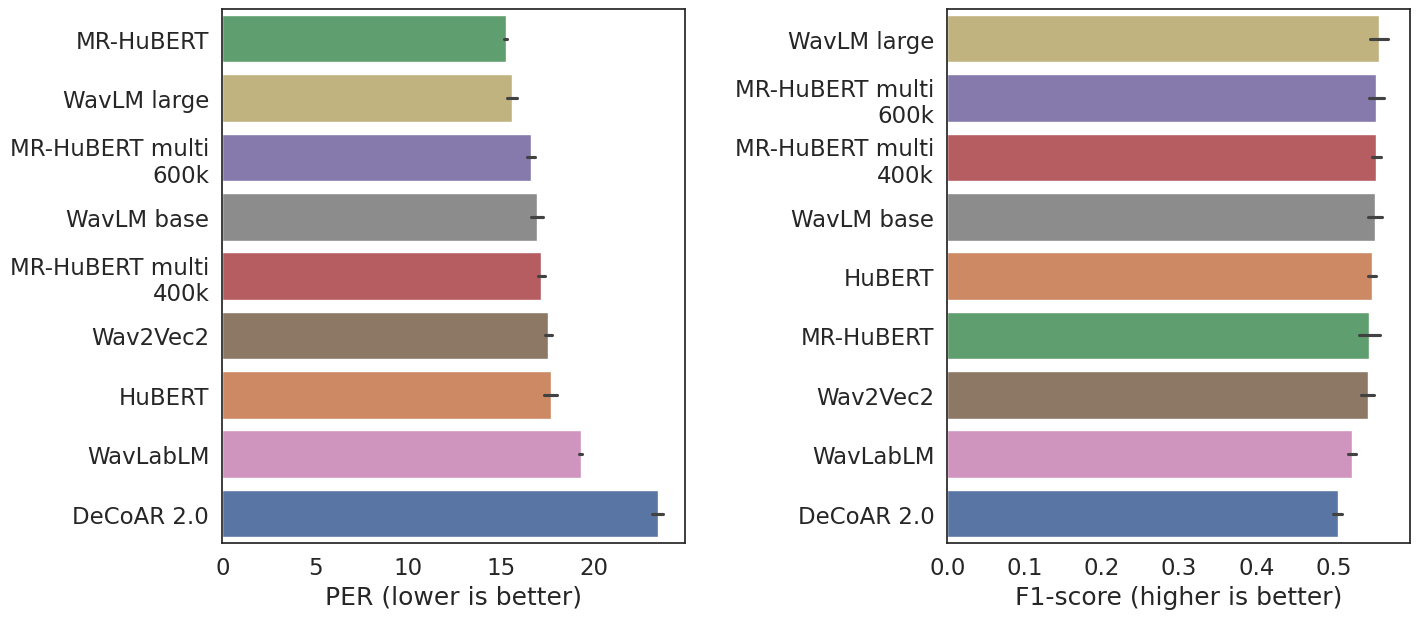

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))


dfx =df['test'].swaplevel(axis=1)['global-per'] * 100
dfx.columns = dfx.columns.to_series().map({k: v.split('\\', 1)[0].strip() for k,v  in name_map.items()}).values
axis = sns.barplot(dfx, orient='y', errorbar='sd', order=dfx.mean().sort_values(ascending=True).index, ax=ax[0])
axis.set_xlabel('PER (lower is better)')
wrap_labels(axis, 15)

dfx =df['test'].swaplevel(axis=1)['global-f1-score']
dfx.columns = dfx.columns.to_series().map({k: v.split('\\', 1)[0].strip() for k,v  in name_map.items()}).values
axis = sns.barplot(dfx, orient='y', errorbar='sd', order=dfx.mean().sort_values(ascending=False).index, ax=ax[1])
axis.set_xlabel('F1-score (higher is better)')
wrap_labels(axis, 15)

plt.tight_layout(pad=2)

In [27]:
dfy = df.loc(axis=1)['test', ['multires_hubert_multilingual_large600k', 'multires_hubert_multilingual_large400k'], ['global-f1-score', 'global-per']]

print("MR-Hubert 400k vs 600k")

dfz = dfy.loc(axis=1)[:, :, 'global-f1-score']
print(f"F1 score diff: {scipy.stats.ttest_ind(dfz.iloc(axis=1)[0], dfz.iloc(axis=1)[1])}")

dfz = dfy.loc(axis=1)[:, :, 'global-per']
print(f"PER diff: {scipy.stats.ttest_ind(dfz.iloc(axis=1)[0], dfz.iloc(axis=1)[1])}")

dfy.mean()

MR-Hubert 400k vs 600k
F1 score diff: Ttest_indResult(statistic=0.053712133274350704, pvalue=0.9584815988904539)
PER diff: Ttest_indResult(statistic=-4.302540671956968, pvalue=0.002606789621176756)


test  multires_hubert_multilingual_large600k  global-f1-score    0.555624
                                              global-per         0.166294
      multires_hubert_multilingual_large400k  global-f1-score    0.555343
                                              global-per         0.171828
dtype: float64

In [28]:

dfy = df.loc(axis=1)['test', ['wavlm_base_plus', 'wavlm_large'], ['global-f1-score', 'global-per', 'global-precision']]

print("WavLM size test")

dfz = dfy.loc(axis=1)[:, :, 'global-f1-score']
print(f"F1 score diff: {scipy.stats.ttest_ind(dfz.iloc(axis=1)[0], dfz.iloc(axis=1)[1])}")

dfz = dfy.loc(axis=1)[:, :, 'global-per']
print(f"PER diff: {scipy.stats.ttest_ind(dfz.iloc(axis=1)[0], dfz.iloc(axis=1)[1])}")

dfz = dfy.loc(axis=1)[:, :, 'global-precision']
print(f"Precision diff: {scipy.stats.ttest_ind(dfz.iloc(axis=1)[0], dfz.iloc(axis=1)[1])}")

dfy.mean()

WavLM size test
F1 score diff: Ttest_indResult(statistic=-0.8692330343582683, pvalue=0.41003929011434215)
PER diff: Ttest_indResult(statistic=7.199976756310926, pvalue=9.245267854094271e-05)
Precision diff: Ttest_indResult(statistic=-3.4238103040786885, pvalue=0.00903698427042227)


test  wavlm_base_plus  global-f1-score     0.553626
                       global-per          0.169321
                       global-precision    0.495981
      wavlm_large      global-f1-score     0.559185
                       global-per          0.155776
                       global-precision    0.513392
dtype: float64

In [29]:


dfy = df.loc(axis=1)['test', ['decoar2', 'wavlm_large'], ['global-f1-score', 'global-per', 'global-precision']]

print("WavLM size test")

dfz = dfy.loc(axis=1)[:, :, 'global-f1-score']
print(f"F1 score diff: {scipy.stats.ttest_ind(dfz.iloc(axis=1)[0], dfz.iloc(axis=1)[1])}")

dfz = dfy.loc(axis=1)[:, :, 'global-per']
print(f"PER diff: {scipy.stats.ttest_ind(dfz.iloc(axis=1)[0], dfz.iloc(axis=1)[1])}")

dfz = dfy.loc(axis=1)[:, :, 'global-precision']
print(f"Precision diff: {scipy.stats.ttest_ind(dfz.iloc(axis=1)[0], dfz.iloc(axis=1)[1])}")

dfy.mean()

WavLM size test
F1 score diff: Ttest_indResult(statistic=-9.41541113478075, pvalue=1.3283796826706812e-05)
PER diff: Ttest_indResult(statistic=44.40971178492924, pvalue=7.295668255320852e-11)
Precision diff: Ttest_indResult(statistic=-28.71341914886222, pvalue=2.341207486160561e-09)


test  decoar2      global-f1-score     0.505515
                   global-per          0.234380
                   global-precision    0.388103
      wavlm_large  global-f1-score     0.559185
                   global-per          0.155776
                   global-precision    0.513392
dtype: float64

In [30]:
dfy = df.loc(axis=1)['test', ['multires_hubert_large', 'multires_hubert_multilingual_large600k']]

print("MR-HuBERT multilingual test")

dfz = dfy.loc(axis=1)[:, :, 'global-f1-score']
print(f"F1 score diff: {scipy.stats.ttest_ind(dfz.iloc(axis=1)[0], dfz.iloc(axis=1)[1])}")

dfz = dfy.loc(axis=1)[:, :, 'global-per']
print(f"PER diff: {scipy.stats.ttest_ind(dfz.iloc(axis=1)[0], dfz.iloc(axis=1)[1])}")

dfz = dfy.loc(axis=1)[:, :, 'global-precision']
print(f"Precision diff: {scipy.stats.ttest_ind(dfz.iloc(axis=1)[0], dfz.iloc(axis=1)[1])}")

dfy.loc(axis=1)[:, :, ['global-f1-score', 'global-precision', 'global-per']].mean()

MR-HuBERT multilingual test
F1 score diff: Ttest_indResult(statistic=-1.181078308119586, pvalue=0.27149112756878935)
PER diff: Ttest_indResult(statistic=-13.988865997471075, pvalue=6.611386547959604e-07)
Precision diff: Ttest_indResult(statistic=10.393093648775935, pvalue=6.360413819863093e-06)


test  multires_hubert_large                   global-f1-score     0.546536
      multires_hubert_multilingual_large600k  global-f1-score     0.555624
      multires_hubert_large                   global-precision    0.519464
      multires_hubert_multilingual_large600k  global-precision    0.493667
      multires_hubert_large                   global-per          0.152538
      multires_hubert_multilingual_large600k  global-per          0.166294
dtype: float64

In [31]:
history['dev_f1_score']

NameError: name 'history' is not defined

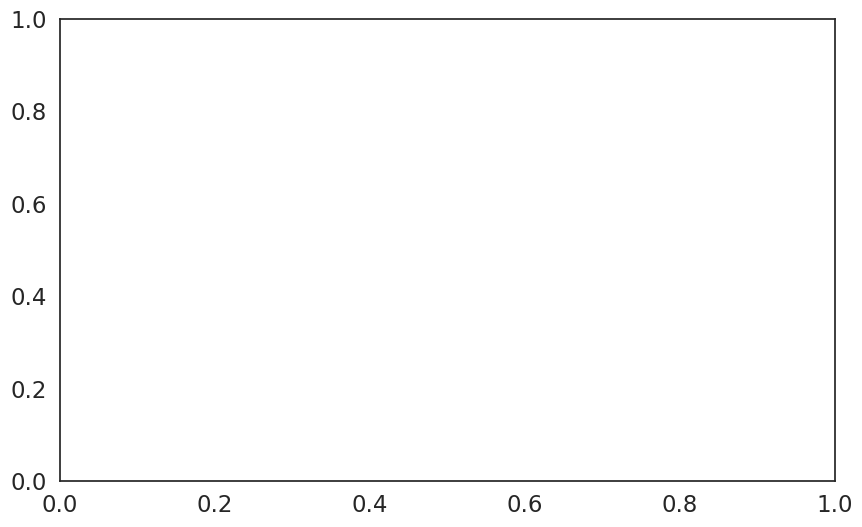

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))
histories = [
            history[f"{split}_f1_score"][aug]
            .reset_index(drop=True)
            .rename(columns=lambda col: f"{aug} | {split}")
            .rename_axis(index="epoch", columns='f1 score')
    for split in ['dev', 'test']
    for aug in models
]

sns.lineplot(
            pd.concat(histories, axis=1),
            errorbar="sd",
            palette='colorblind'
        ).set(ylabel='f1 score',
xticks=list(range(0, 20, 2)))

plt.savefig('f1_scores.png')

# plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [ ]:
scipy.stats.ttest_ind(
    history['test_f1_score']['phase_perturbation'].iloc[3],
    history['test_f1_score']['phase_perturbation'].iloc[15],
)

In [ ]:
history['test_f1_score']['phase_perturbation'].iloc[3]

In [ ]:
history['test_f1_score']['phase_perturbation'].iloc[19]